In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
workspaceFolder = "/home/gabor/Projects/bnn_seq_vi"
seq_args = [
    "--seed=3",
    # "--weight_decay=15",
    # f"--pretrained_prior_checkpoint={workspaceFolder}/bnn_hmc/.runs/vi/regtest2/mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.001___epochs_300_wd_0.5_batchsize_1_temp_1.0__seed_11/model_step_299.pt",
    f"--dir={workspaceFolder}/bnn_hmc/.runs/sgd/visualize/",
    "--dataset_name=regtest_1",
    "--model_name=bayesian_regression",
    # "--init_step_size=1e-4",
    # "--num_epochs=500",
    # "--eval_freq=50",
    # "--batch_size=1",
    # "--save_freq=500",
    # "--vi_sigma_init=1e-3",
]

In [4]:
import os
import pandas as pd
import importlib
os.chdir("../..")

In [5]:
from jax import numpy as jnp
import jax
import pandas as pd
import tensorflow.compat.v2 as tf
import argparse

from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import optim_utils
from bnn_hmc.utils import script_utils
from bnn_hmc.core import vi

parser = argparse.ArgumentParser(description="Run SGD on a cloud TPU")
cmd_args_utils.add_common_flags(parser)
cmd_args_utils.add_sgd_flags(parser)
parser.add_argument("--vi_sigma_init", default=1e-3)

args = parser.parse_args(seq_args)
train_utils.set_up_jax(args.tpu_ip, args.use_float64)

2024-09-14 19:27:24.554678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-14 19:27:25.220381: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
(train_set, test_set, net_apply, params, net_state, key, log_likelihood_fn,
   log_prior_fn, _, predict_fn, ensemble_upd_fn, metrics_fns,
   tabulate_metrics) = script_utils.get_data_model_fns(args)

2024-09-14 19:27:26.298806: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8250458112
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
SGD_CHECKPOINT = f"{workspaceFolder}/bnn_hmc/.runs/sgd/regtest/"\
                 "sgd_mom_0.9__lr_sch_i_0.0005___epochs_500_wd_10.0_batchsize_1_temp_1.0__seed_1/model_step_499.pt"

In [11]:
sgd_params = checkpoint_utils.load_checkpoint(SGD_CHECKPOINT)['params']
sgd_params

{'linear': {'b': Array([0.14621593, 0.00249196], dtype=float32),
  'w': Array([[-0.14621599, -0.0024919 ]], dtype=float32)}}

In [13]:
_, test_predictions, train_predictions, test_stats, train_stats_ = script_utils.evaluate(net_apply, sgd_params, net_state, train_set,
                                test_set, predict_fn, metrics_fns,
                                log_prior_fn)

In [15]:
map_mean = test_predictions[0, ..., 0]
predictive_std = test_predictions[0, ..., 1]

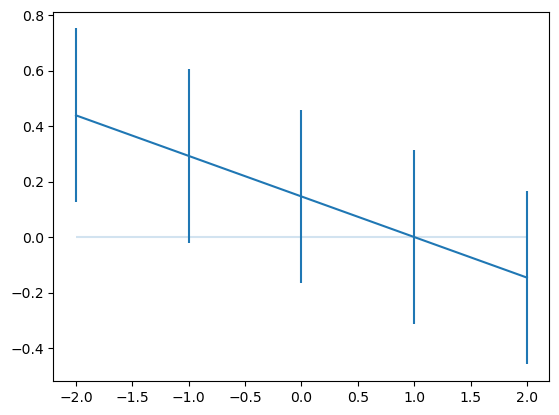

In [16]:
test_x = test_set[0][0, ..., 0]
plt.errorbar(test_x, map_mean, yerr=predictive_std)
plt.hlines(y=0, xmin=-2, xmax=2, alpha=0.2)
plt.show()